In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.metrics import MeanSquaredError

In [3]:
df = pd.read_csv ('/content/drive/MyDrive/Colab Notebooks/sanjaghshare/data/dfn3share.csv')
dffull = pd.read_csv ('/content/drive/MyDrive/Colab Notebooks/sanjaghshare/data/taskfullshare.csv')

In [4]:
num_users = df.user.nunique()
num_service = df.service.nunique()
num_cats=df.subcat.nunique()


In [ ]:
num_users , num_service , num_cats , 

(426026, 301, 55)

### old data prep

In [ ]:
# dfc = pd.read_csv ("/content/drive/MyDrive/Colab Notebooks/sanjagh/Recommand/data/dfc.csv")
# dfn = pd.read_csv ("/content/drive/MyDrive/Colab Notebooks/sanjagh/Recommand/data/dfn.csv")
# dfsc = pd.read_csv ("/content/drive/MyDrive/Colab Notebooks/sanjagh/Recommand/data/dfsc.csv")
# dfsc.drop(columns='Unnamed: 0', inplace=True)

In [ ]:
# dfsc= dfsc[dfsc.customerId != "behtarino"]
# filterdf=dfsc.groupby(by=['customerId']).count()
# indexlist= filterdf[filterdf['count']==1].index.values

In [ ]:
# servicesdf = pd.read_csv ('/content/drive/MyDrive/Colab Notebooks/sanjagh/Recommand/data/services.csv', index_col='Unnamed: 0')
# catsdf = pd.read_csv ('/content/drive/MyDrive/Colab Notebooks/sanjagh/Recommand/data/cats.csv', index_col='Unnamed: 0')
# subcatsdf = pd.read_csv ('/content/drive/MyDrive/Colab Notebooks/sanjagh/Recommand/data/subcats.csv', index_col='Unnamed: 0')

# subcatsdf.rename(columns={'id':'subcatid' , 'title':'subcat_title'} , inplace=True)
# servicesdf.rename(columns={'id':'serviceId' , 'title':'service_title'} , inplace=True)
# catsdf.rename(columns={'id':'catid', 'title':'cat_title'} , inplace=True)

In [ ]:
# dfn= pd.merge(dfn, servicesdf, on="serviceId")

In [ ]:
# dfsc = pd.merge(dfsc, servicesdf, on="serviceId")

In [ ]:
# user_ids = dfc.customerId.tolist()
# user2user_encoded = {x: i for i, x in enumerate(user_ids)}
# userencoded2user = {i: x for i, x in enumerate(user_ids)}

# subcatid = subcatsdf.subcatid.tolist()
# subcatid_encoded = {x: i for i, x in enumerate(subcatid)}
# coded2subcat = {i: x for i, x in enumerate(subcatid)}

# ser_ids =dfn.serviceId.tolist()
# ser_encoded = {x: i for i, x in enumerate(ser_ids)}
# ser_encoded2ser = {i: x for i, x in enumerate(ser_ids)}

# dfsc["customer"] = dfsc["customerId"].map(user2user_encoded)
# dfsc["service"] = dfsc["serviceId"].map(ser_encoded)
# dfsc["subcat"] = dfsc["subcatid"].map(subcatid_encoded)
# dfn["subcat"]=dfn["subcatid"].map(subcatid_encoded)
# dfc["customer"] = dfc["customerId"].map(user2user_encoded)
# dfn["service"] = dfn["serviceId"].map(ser_encoded)

# num_users = len(user2user_encoded)
# num_service = len(ser_encoded)
# num_cats=len(subcatid_encoded)

# dfsc["count"] = dfsc["count"].values.astype(np.float32)
# # min and max ratings will be used to normalize the ratings later
# min_count = min(dfsc["count"])
# max_count = max(dfsc["count"])

# print(
#     "Number of users: {}, Number of services: {}, Min rating: {}, Max rating: {}".format(
#         num_users, num_service, min_count, max_count
#     )
# )

In [ ]:

# dfc.to_csv("/content/drive/MyDrive/Colab Notebooks/sanjagh/dfc.csv", index=False)
# dfn.to_csv("/content/drive/MyDrive/Colab Notebooks/sanjagh/dfn.csv", index=False)
# dfsc.to_csv("/content/drive/MyDrive/Colab Notebooks/sanjagh/dfsc.csv", index=False)

In [ ]:
# from sklearn.preprocessing import LabelEncoder, StandardScaler,OrdinalEncoder
# train_df=dfsc
# service_encoder = OrdinalEncoder()
# # gender_encoder = LabelEncoder()
# customer_encoder = OrdinalEncoder()
# train_df['service'] = service_encoder.fit_transform(train_df['service'])
# # train_df['user_gender'] = gender_encoder.fit_transform(train_df['user_gender'])
# train_df['customer'] = customer_encoder.fit_transform(train_df['customer'])

### Modell

In [5]:
dfscsample = df.sample(frac=0.8, random_state=42)
x = dfscsample[["user", "service" , "subcat" , 'gender' ]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
min_count = min(df["count"])
max_count = max(df["count"])
y = dfscsample["count"].apply(lambda x: (x - min_count) / (max_count - min_count)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * dfscsample.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [6]:
#@title RecommenderNet model with gender and cat

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_service, num_categories, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_service = num_service
        self.num_categories = num_categories
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
  
        self.service_embedding = layers.Embedding(
            num_service,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.service_bias = layers.Embedding(num_service, 1)

        self.category_embedding = layers.Embedding(
            num_categories,
            embedding_size // 2,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )

        self.gender_embedding = layers.Embedding(
            4,
            embedding_size // 2,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )

          # Additional dense layers
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(32, activation='relu')
        
        # Output layer
        self.output_layer = layers.Dense(1, activation='sigmoid')


    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
       
        service_vector = self.service_embedding(inputs[:, 1])
        service_bias = self.service_bias(inputs[:, 1])
        category_vector = self.category_embedding(inputs[:, 2])
        gender_vector = self.gender_embedding(inputs[:, 3])
        # Concatenate the user and age embeddings
        user_gender_vector = layers.concatenate([user_vector, gender_vector])
        # Concatenate the service and category embeddings
        service_category_vector = layers.concatenate([service_vector, category_vector])
        dot_user_service = tf.tensordot(user_gender_vector, service_category_vector, 2)
        # Add all the components (including biases)
        x = dot_user_service + user_bias + service_bias

        x = self.dense1(x)
        x = self.dense2(x)
         # Flatten and pass through output layer
        x = layers.Flatten()(x)
        x = self.output_layer(x)

        return x



In [ ]:
# embedding_size=100
# num_users_per_service = df.groupby('service')['user'].nunique()

# # num_users_per_service=num_users/df['count'].sum()
# # num_service_per_user= num_service/df['count'].sum()
# service_freq = np.sum(num_users_per_service) / (num_service * num_users)
# # user_freq = np.sum(num_service_per_user) / (num_service * num_users)
# movie_embedding_size = int(embedding_size * (1 + np.log(service_freq)))
# # user_embedding_size = int(embedding_size * (1 + np.log(user_freq)))
# movie_embedding_size , service_freq#, user_embedding_size


(-371, 0.008919253489325039)

In [ ]:
#@title RecommenderNet model, Embedding size

# Compute the frequency of each movie and user in the training data
       

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_service, num_categories, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_service = num_service
        self.num_categories = num_categories
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1, embeddings_initializer="zeros")
  
        self.service_embedding = layers.Embedding(
            num_service,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.service_bias = layers.Embedding(num_service, 1, embeddings_initializer="zeros")

        self.category_embedding = layers.Embedding(
            num_categories,
            embedding_size // 2,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )

        self.gender_embedding = layers.Embedding(
            3,
            embedding_size // 2,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # num_users_per_service=num_users/df['count'].sum()
        # num_service_per_user= num_service/df['count'].sum()
        # service_freq = np.sum(num_users_per_service) / (num_service * num_users)
        # user_freq = np.sum(num_service_per_user) / (num_service * num_users)
        
        # # Adjust the embedding size and bias initialization based on the frequency
        # movie_embedding_size = int(embedding_size * (1 + np.log(service_freq)))
        # user_embedding_size = int(embedding_size * (1 + np.log(user_freq)))
        user_embedding_size=300
        movie_embedding_size = 100


    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
       
        service_vector = self.service_embedding(inputs[:, 1])
        service_bias = self.service_bias(inputs[:, 1])
        category_vector = self.category_embedding(inputs[:, 2])
        gender_vector = self.gender_embedding(inputs[:, 3])
        # Concatenate the user and age embeddings
        user_gender_vector = layers.concatenate([user_vector, gender_vector])
        # Concatenate the service and category embeddings
        service_category_vector = layers.concatenate([service_vector, category_vector])
        dot_user_service = tf.tensordot(user_gender_vector, service_category_vector, 2)
        # Add all the components (including biases)
        x = dot_user_service + user_bias + service_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

# model with 3 input

In [ ]:
EMBEDDING_SIZE = 100


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_service,num_cats, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_service = num_service
        self.num_cats=num_cats
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.services_embedding = layers.Embedding(
            num_service,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.services_bias = layers.Embedding(num_service, 1)

        
        self.cats_embedding = layers.Embedding(
            num_cats,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.cats_bias = layers.Embedding(num_cats, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        services_vector = self.services_embedding(inputs[:, 1])
        services_bias = self.services_bias(inputs[:, 1])
        
        cats_vector = self.cats_embedding(inputs[:, 2])
        cats_bias = self.cats_bias(inputs[:, 2])

        dot_user_services = tf.tensordot(user_vector, services_vector, 2)
        # Add all the components (including bias)
        x = dot_user_services + user_bias + services_bias + cats_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


)

# Train

In [9]:


EMBEDDING_SIZE = 25
num_users = 1514100
num_service = 589
num_cats = 81


model = RecommenderNet(num_users, num_service,num_cats, EMBEDDING_SIZE)
model.compile( loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = MeanSquaredError())

In [11]:
history = model.fit(    x=x_train, y=y_train,  batch_size=32, epochs=2,  verbose=1, validation_data=(x_val, y_val))
model.save("/content/drive/MyDrive/Colab Notebook/sanjagh/Recommand/savedmodels/modelEmbedDense")

Epoch 1/2
25735/25735 [==============================] - 428s 17ms/step - loss: 0.0244 - mean_squared_error: 8.3968e-05 - val_loss: 0.0245 - val_mean_squared_error: 9.2750e-05
Epoch 2/2
25735/25735 [==============================] - 414s 16ms/step - loss: 0.0242 - mean_squared_error: 8.2551e-05 - val_loss: 0.0245 - val_mean_squared_error: 9.2434e-05


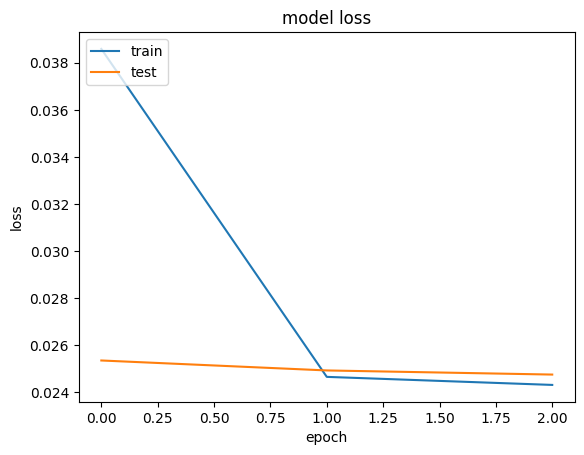

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()